In [2]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import math

In [3]:
#Relações na lista de parentes
#1. Pais do homem [0]
#2. Pais da mulher [1]
#3. Filhos [2]
#4. Avos [3] 
#5. Irmãos [4]
#6. Tios [5]
#7. Primos [6]
#8. Netos [7]
#9. Sobrinhos [8]
#10. Cassais passados [9]

# Classe UD   

In [4]:
class UD:
    #Dict de todas as UDs
    uds = {}
    
    def __init__(self,id_ud):
        self.id = id_ud
        self.parentes = [None]*10
        self.age = 1
        self.not_married_children = 2 #Numero maximo de filhos por UD. Pode ser trocado só por uma probabilidade
        self.uds[id_ud] = self
        self.activa = True ########################### Olhar 
    
    def incrementar_idade(self):
        self.age += 1

    def death_probability(self): #Ainda não utilizei
        alpha = 0.001
        beta = 0.09
        delta = 0.01

        mortality_rate = alpha * math.exp(beta * self.age) + delta

        if random.random() < mortality_rate:
            del self.uds[self.id] ### activa False 
            return True
        else:
            return False
        
    def buscar_ud(self): #metodo para buscar e reproducir. 
        if self.not_married_children > 0 and random.random() < 0.05 and self.age > 8:
            #Função para facilitar a busqueda de ids dentro da lista de parentes.
            def is_id_in_nested_lists(id_ud, nested_list):
                if id_ud in nested_list:
                    return True
                for sublist in nested_list:
                    if isinstance(sublist, list) and is_id_in_nested_lists(id_ud, sublist):
                        return True
                return False
            #Filtro para escolher outra UD para criar uma nova UD
            uds_disponiveis = [id_ud for id_ud, ud in self.uds.items() if 
                   id_ud != self.id and #Que a UD não seja self mesmo
                   not is_id_in_nested_lists(id_ud, self.parentes) and  # Que a UD não seja um parente
                   ud.not_married_children > 0 and # Que a UD tenha filhos disponiveis
                   ud.age > 8 and # QUe a idade seja maior a 8. (não sei se preciso disso)
                   abs(ud.age - self.age) <= 10] #Que a diferença entre as idades não seja maior a 10
            
            uds_disponiveis_sem_self_como_padre = [id_ud for id_ud in uds_disponiveis if 
                                      not is_id_in_nested_lists(self.id, self.uds[id_ud].parentes) #QUe a UD não seja um parente
                                                  ] 
            #Escolher uma UD da lista de uds_disponiveis_sem_self_como_padre e modificar
            if uds_disponiveis_sem_self_como_padre:
                cassal_id = random.choice(uds_disponiveis_sem_self_como_padre) #Cassal aleatorio da lista criada
                #Agregar no espaço de casais passados [9]
                if self.parentes[9] is None: 
                    # Se a lista não existe, cria uma nova com esse id
                    self.parentes[9] = [cassal_id]
                else:
                    # Se a lista já existe, só agrega o id
                    self.parentes[9].append(cassal_id)
                if self.uds[cassal_id].parentes[9] is None: 
                    # Se a lista não existe, cria uma nova com esse id
                    self.uds[cassal_id].parentes[9] = [self.id]
                else:
                    # Se a lista já existe, só agrega o id
                    self.uds[cassal_id].parentes[9].append(self.id)   

                #### Criar um novo filho e asignar os parentes
                novo_id = max(self.uds) + 1 
                novo_nodo = UD(novo_id)
                novo_nodo.parentes[0] = self.id   # Pais do homem [0]
                novo_nodo.parentes[1] = cassal_id # Pais da mulher [1] 
                
                #####Avos[3]
                # IDs do pai
                padre_self = self.parentes[0]
                madre_self = self.parentes[1]
                # IDs da mae
                pareja = self.uds[cassal_id]
                padre_pareja = pareja.parentes[0]
                madre_pareja = pareja.parentes[1]
                # Agregar os pais dos pais do novo_nodo como avos
                novo_nodo.parentes[3] = [valor for valor in [padre_self, madre_self, padre_pareja, madre_pareja] if valor is not None]
                ###Proceso de atualização: netos
                # Se novo_nodo tem avos 
                if None not in novo_nodo.parentes[3]:
                    # IDs dos avos de novo_nodo
                    abuelos_ids = novo_nodo.parentes[3]
                # Agregar aos avos o novo_nodo como neto.
                for abuelo_id in abuelos_ids:
                    if abuelo_id is not None:
                        abuelo = self.uds[abuelo_id]
                        if abuelo.parentes[7] is None:
                            abuelo.parentes[7] = [novo_nodo.id]
                        else:
                            abuelo.parentes[7].append(novo_nodo.id)
                
                #### Irmãos [4]
                hermanos_ids = []
                if novo_nodo.parentes[0] is not None:
                    # Filhos dos pais do novo_nodo (irmãos por parte do pai)
                    padre_nuevo = self.uds[novo_nodo.parentes[0]]
                    if padre_nuevo.parentes[2] is not None:
                        hermanos_ids.extend(padre_nuevo.parentes[2])
                if novo_nodo.parentes[1] is not None:
                    # Filhos dos pais do novo_nodo (irmãos por parte da mãe)
                    madre_nuevo = self.uds[novo_nodo.parentes[1]]
                    if madre_nuevo.parentes[2] is not None:
                        hermanos_ids.extend(madre_nuevo.parentes[2])
                # Não ter o id de novo_nodo como irmão
                hermanos_ids = [hermano_id for hermano_id in hermanos_ids if hermano_id != novo_nodo.id]
                # Agregar aos irmãos de novo_nodo
                novo_nodo.parentes[4] = hermanos_ids
                
                ##Proceso de atualização: irmãos
                # ID de novo_nodo nos irmãos existentes
                for hermano_id in hermanos_ids:
                    hermano = self.uds[hermano_id]
                    if hermano.parentes[4] is None:
                        hermano.parentes[4] = [novo_nodo.id]
                    else:
                        hermano.parentes[4].append(novo_nodo.id)

    
                #####Tios[5]
                # IDs dos avos de novo_nodo
                abuelos_ids = novo_nodo.parentes[3]
                
                # Iterar nos avos para encontrar os tios
                tios_ids = [hermano_id for abuelo_id in abuelos_ids if abuelo_id is not None
                            for hermano_id in self.uds[abuelo_id].parentes[2] if hermano_id is not None
                            if hermano_id != novo_nodo.parentes[0] and hermano_id != novo_nodo.parentes[1]]
                # Agregar os IDs dos tios no novo_nodo
                novo_nodo.parentes[5] = tios_ids
                
                ##Proceso de atualização: sobrinhos
                # Actualizar os sobrinhos dos tios.
                for tio_id in tios_ids:
                    if tio_id is not None:
                        tio = self.uds[tio_id]
                        if tio.parentes[8] is None:
                            # Se não existe, cria lisa com o id de novo_nodo
                            tio.parentes[8] = [novo_nodo.id]
                        else:
                            # Se existe, agregar o id de novo_nodo
                            tio.parentes[8].append(novo_nodo.id)
                
                #### Primos[6]
                primos_ids = [primo_id for tio_id in tios_ids if tio_id is not None
                             for tio in [self.uds[tio_id]] if tio.parentes[2] is not None
                             for primo_id in tio.parentes[2] if primo_id is not None and primo_id != novo_nodo.id]

                # Agregar os IDs dos primos no novo_nodo
                novo_nodo.parentes[6] = primos_ids
                
                ##Proceso de atualização: sobrinhos
                for primo_id in primos_ids:
                    if primo_id is not None:
                        primo = self.uds[primo_id]
                        if primo.parentes[6] is None:
                            # Se não existe, cria lisa com o id de novo_nodo
                            primo.parentes[6] = [novo_nodo.id]
                        else:
                            # Se existe, agregar o id de novo_nodo
                            primo.parentes[6].append(novo_nodo.id)
                            
                ####Sobrinos[8] 
                sobrinos_ids = [sobrino_id for hermano_id in hermanos_ids if hermano_id is not None
                               for hermano in [self.uds[hermano_id]] if hermano.parentes[2] is not None
                               for sobrino_id in hermano.parentes[2] if sobrino_id is not None and sobrino_id != novo_nodo.id]

                # Agregar os IDs dos sobrinhos no novo_nodo
                novo_nodo.parentes[8] = sobrinos_ids
                
                ##Proceso de atualização: tios
                for sobrino_id in sobrinos_ids:
                    if sobrino_id is not None:
                        sobrino = self.uds[sobrino_id]
                        if sobrino.parentes[5] is None:
                            # Se não existe, cria lisa com o id de novo_nodo
                            sobrino.parentes[5] = [novo_nodo.id]
                        else:
                            # Se existe, agregar o id de novo_nodo
                            sobrino.parentes[5].append(novo_nodo.id)
                
                #restar o numero de filhos
                self.not_married_children -= 1
                self.uds[cassal_id].not_married_children -= 1
                # colcoar o novo filho dos pais
                if self.parentes[2] is None:
                    self.parentes[2] = [novo_id]
                else:
                    self.parentes[2].append(novo_id)
                if self.uds[cassal_id].parentes[2] is None:
                    self.uds[cassal_id].parentes[2] = [novo_id]
                else:
                    self.uds[cassal_id].parentes[2].append(novo_id)
                 
                return None
            else:
                print(f"UD {self.id} não achou cassal.")
                return None

        else:
            #print(f"UD {self.id} não acho ninguem")
            return None

In [5]:
n=10
instancias_ud = [UD(id) for id in range(1, n + 1)]  # Crear n instancias com IDs del 1 al n

# Imprimir as IDs das instancias criadas
for instancia in instancias_ud:
    print(f"Instancia UD con ID {instancia.id} creada.")

Instancia UD con ID 1 creada.
Instancia UD con ID 2 creada.
Instancia UD con ID 3 creada.
Instancia UD con ID 4 creada.
Instancia UD con ID 5 creada.
Instancia UD con ID 6 creada.
Instancia UD con ID 7 creada.
Instancia UD con ID 8 creada.
Instancia UD con ID 9 creada.
Instancia UD con ID 10 creada.


In [6]:
#Simulación
random.seed(42)
n=100
for i in range(n):
    uds_copy = dict(UD.uds) #As UDs existentes no tempo n 
    for id_ud, ud in uds_copy.items():
        #ud.death_probability()
        ud.buscar_ud()
        ud.incrementar_idade()

UD 13 não achou cassal.
UD 13 não achou cassal.
UD 13 não achou cassal.
UD 31 não achou cassal.
UD 15 não achou cassal.
UD 26 não achou cassal.
UD 25 não achou cassal.
UD 13 não achou cassal.
UD 15 não achou cassal.


In [7]:
#Unidades
print(len(UD.uds))

for id, nodo in UD.uds.items():
    #print(nodo.id)
    print(f"""
    ID : {nodo.id},    
    Padre: {nodo.parentes[0]},    
    Madre: {nodo.parentes[1]}
    Hijos: {nodo.parentes[2]},    
    Abuelos: {nodo.parentes[3]},    
    Hermanos:{nodo.parentes[4]}
    Tios:{nodo.parentes[5]},    
    Primos: {nodo.parentes[6]},    
    Nietos: {nodo.parentes[7]}
    Sobrinos: {nodo.parentes[8]}
    Hijos disponibles: {nodo.not_married_children}
    Parejas pasadas: {nodo.parentes[9]}
    Edad: {nodo.age}
    """)

36

    ID : 1,    
    Padre: None,    
    Madre: None
    Hijos: [16, 18],    
    Abuelos: None,    
    Hermanos:None
    Tios:None,    
    Primos: None,    
    Nietos: [23, 24, 25, 26]
    Sobrinos: None
    Hijos disponibles: 0
    Parejas pasadas: [3, 11]
    Edad: 101
    

    ID : 2,    
    Padre: None,    
    Madre: None
    Hijos: [11, 22],    
    Abuelos: None,    
    Hermanos:None
    Tios:None,    
    Primos: None,    
    Nietos: [18, 20, 29, 32]
    Sobrinos: None
    Hijos disponibles: 0
    Parejas pasadas: [10, 9]
    Edad: 101
    

    ID : 3,    
    Padre: None,    
    Madre: None
    Hijos: [16, 17],    
    Abuelos: None,    
    Hermanos:None
    Tios:None,    
    Primos: None,    
    Nietos: [24, 25, 26, 32]
    Sobrinos: None
    Hijos disponibles: 0
    Parejas pasadas: [1, 5]
    Edad: 101
    

    ID : 4,    
    Padre: None,    
    Madre: None
    Hijos: [21],    
    Abuelos: None,    
    Hermanos:None
    Tios:None,    
    Primos: None,

# Grafico general:
Todas as conexões de todos os nós.

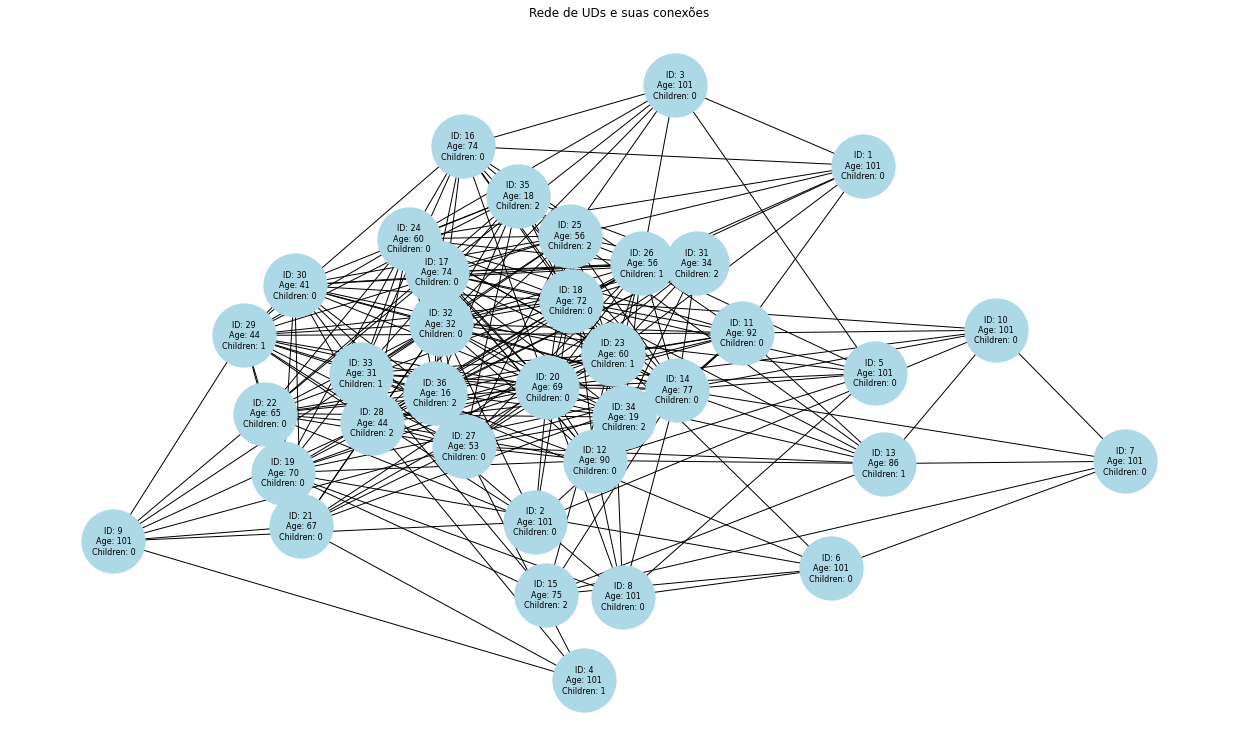

36


In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# Função para olhar listas dentro de listas 
def lista_em_listas(graph, node_id, nested_list):
    for item in nested_list:
        if isinstance(item, list):
            lista_em_listas(graph, node_id, item)
        elif item is not None:
            graph.add_edge(node_id, item)

G = nx.Graph()

# Iterar nas instancias de UD no dictionary'uds'
for id_ud, ud in UD.uds.items():
    # nó por cada UD
    G.add_node(id_ud, ID=id_ud, age=ud.age, not_married_children=ud.not_married_children)

    # conexões da lista de parentes
    lista_em_listas(G, id_ud, ud.parentes)

# Grafico
pos = nx.spring_layout(G, k=1)
node_labels = {node: f"ID: {G.nodes[node]['ID']}\nAge: {G.nodes[node]['age']}\nChildren: {G.nodes[node]['not_married_children']}" for node in G.nodes}
plt.figure(figsize=(17, 10))
nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=4000, node_color='lightblue', font_size=8, font_color='black')
plt.title("Rede de UDs e suas conexões")
plt.show()
print(len(G.nodes))


# Grafico geral
So conexões com pais

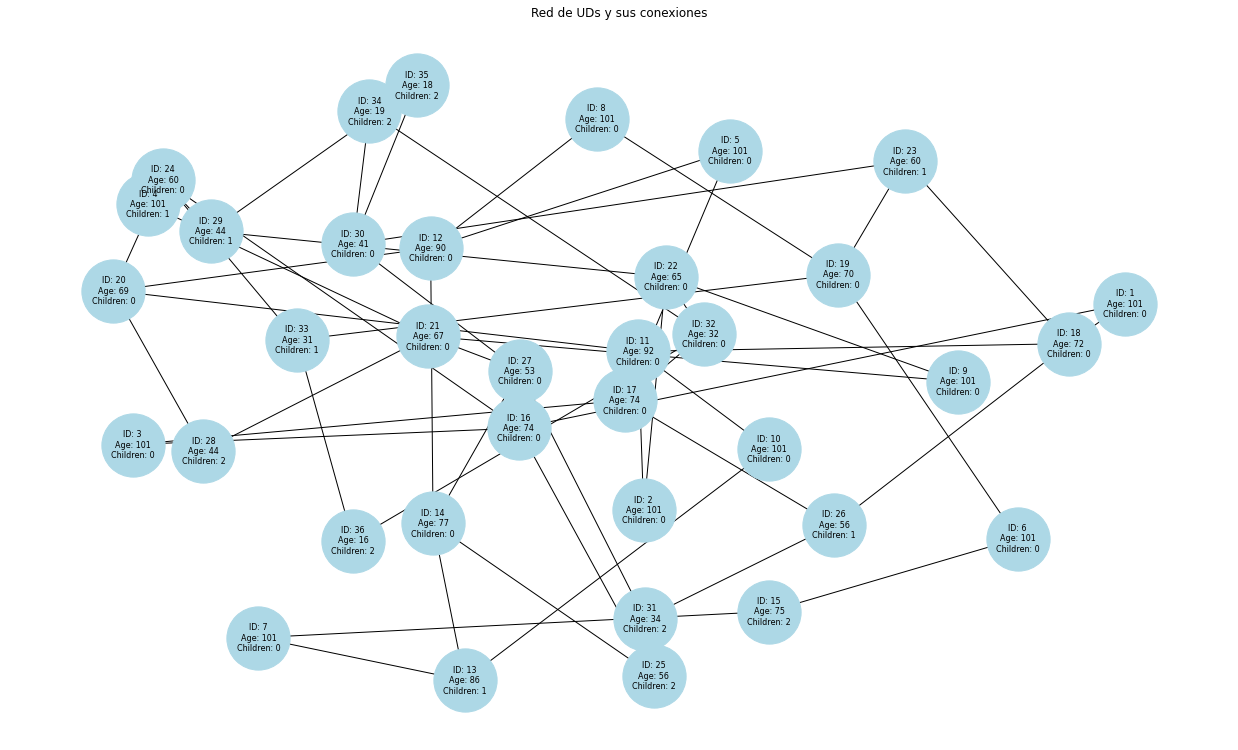

36


In [9]:
G = nx.Graph()

# Iterar nas instancias de UD no dictionary'uds'
for id_ud, ud in UD.uds.items():
    # nó por cada UD
    G.add_node(id_ud, ID=id_ud, age=ud.age, not_married_children=ud.not_married_children)
    # Só conectar com pais
    if ud.parentes[0] is not None:
        G.add_edge(id_ud, ud.parentes[0])
    if ud.parentes[1] is not None:
        G.add_edge(id_ud, ud.parentes[1])

# Grafico
pos = nx.spring_layout(G, k=1)
node_labels = {node: f"ID: {G.nodes[node]['ID']}\nAge: {G.nodes[node]['age']}\nChildren: {G.nodes[node]['not_married_children']}" for node in G.nodes}
plt.figure(figsize=(17, 10))
nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=4000, node_color='lightblue', font_size=8, font_color='black')
plt.title("Red de UDs y sus conexiones")
plt.show()
print(len(G.nodes))

# Grafico egocentrico
Rede de cada nó para fazer troca de sementes

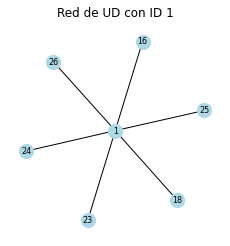

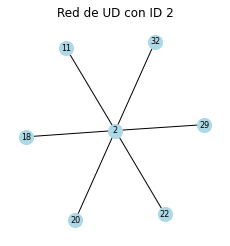

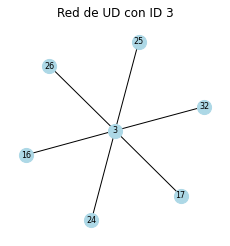

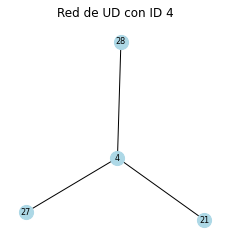

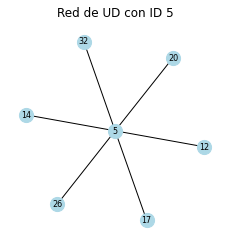

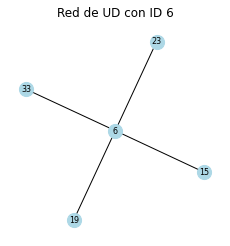

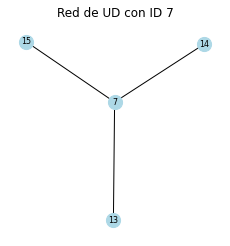

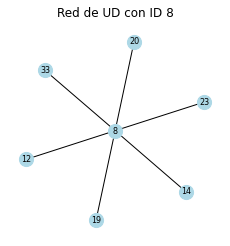

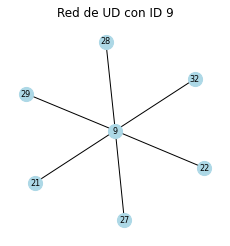

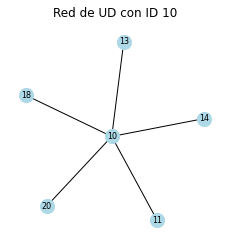

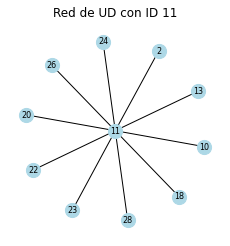

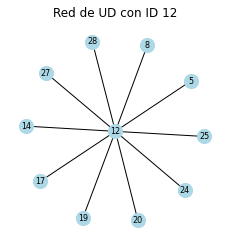

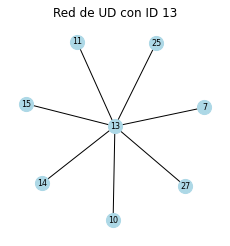

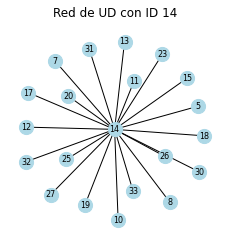

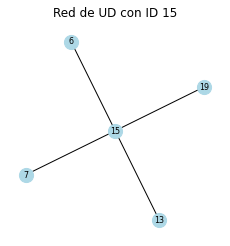

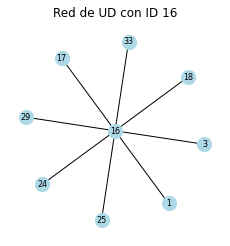

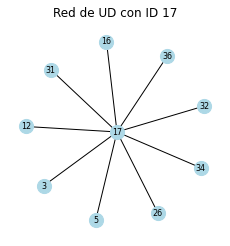

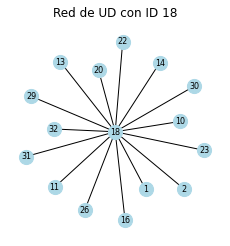

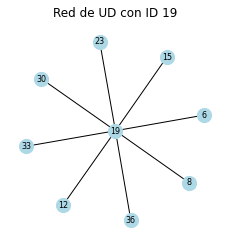

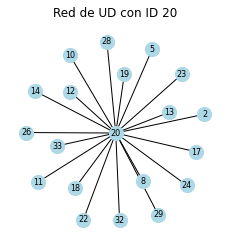

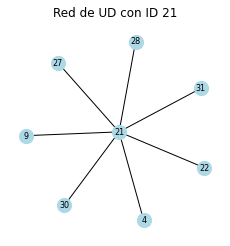

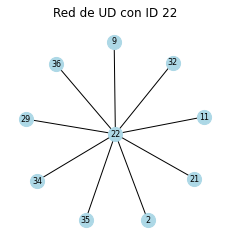

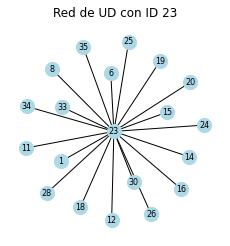

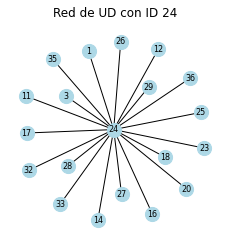

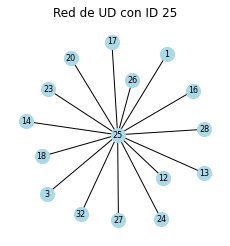

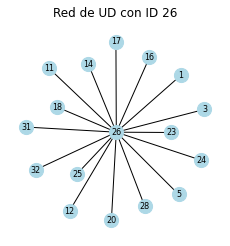

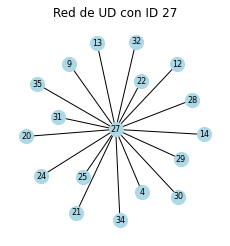

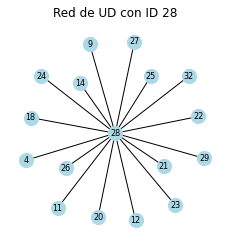

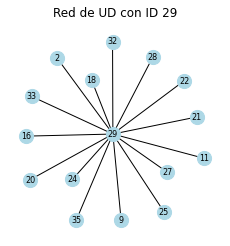

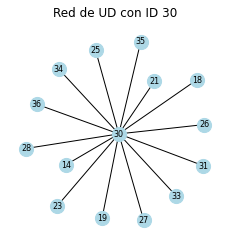

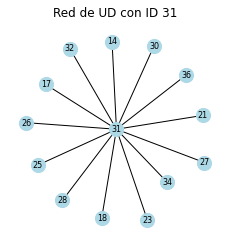

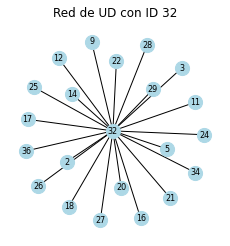

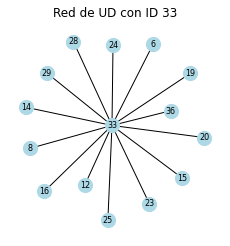

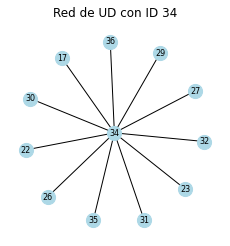

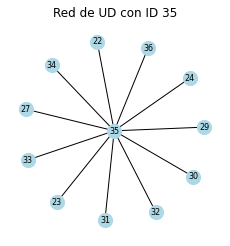

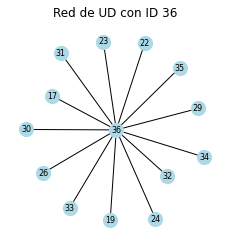

In [10]:
# Rede individual
for id_ud, ud in UD.uds.items():
    red_ud = nx.Graph()
    red_ud.add_node(id_ud)
    
    # parentes dessa UD
    parentes = ud.parentes[0:8]
    
    # Agregar os nós desde a lista de parentes.
    for nodo in parentes:
        if nodo is not None:
            if isinstance(nodo, list):
                red_ud.add_nodes_from(nodo)  # Agregar todos os elementos da lista como nos
            else:
                red_ud.add_node(nodo)
    
    # Conectar los nodos
    for nodo1 in red_ud.nodes:
        if nodo1 is not id_ud:
            red_ud.add_edge(id_ud, nodo1)

    
    # Mostrar el gráfico resultante
    plt.figure(figsize=(3, 3))
    pos = nx.spring_layout(red_ud, k=0.5)
    nx.draw(red_ud, pos, with_labels=True, node_size=200, node_color='lightblue', font_size=8, font_color='black')
    plt.title(f'Red de UD con ID {id_ud}')
    plt.show()

# Rede "Genealogica" egocentrica

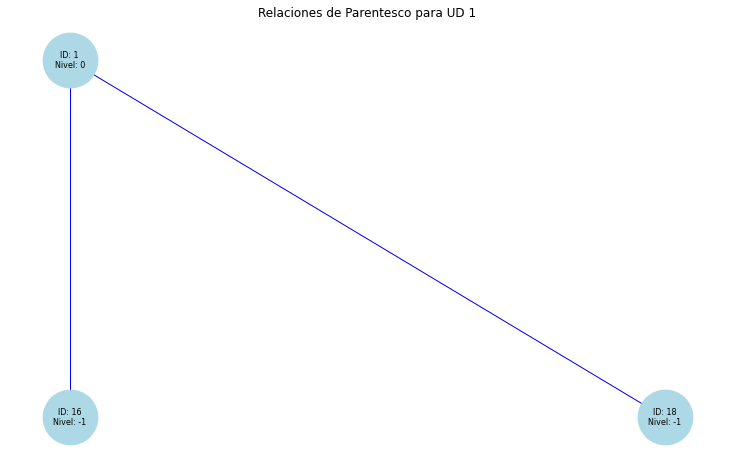

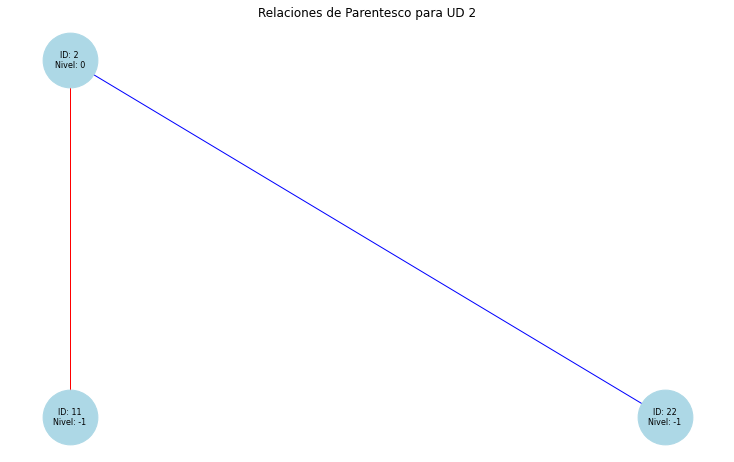

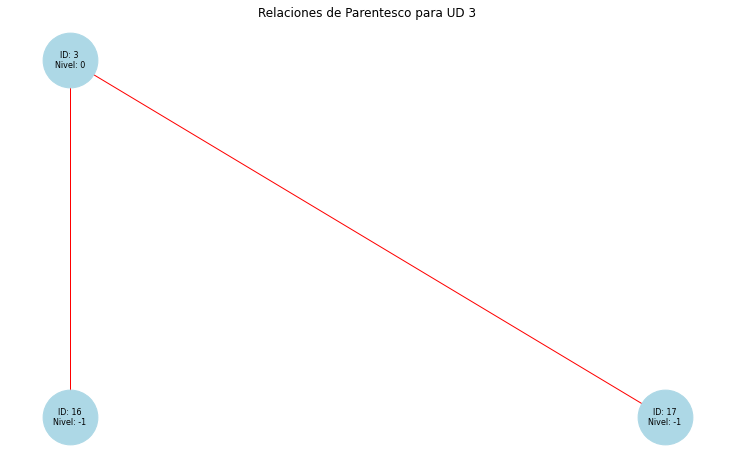

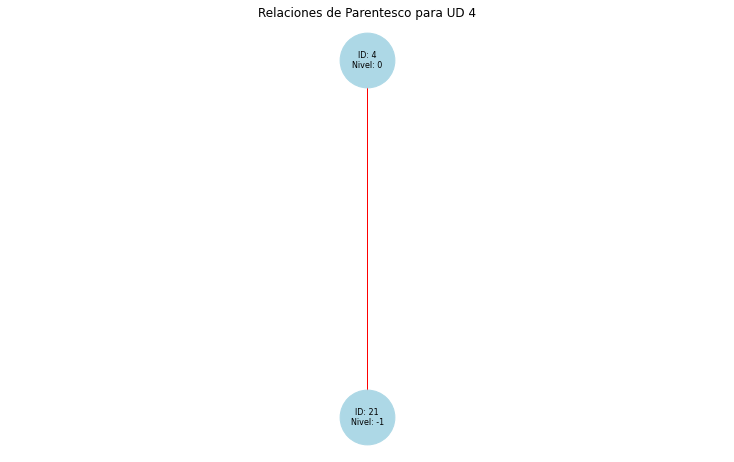

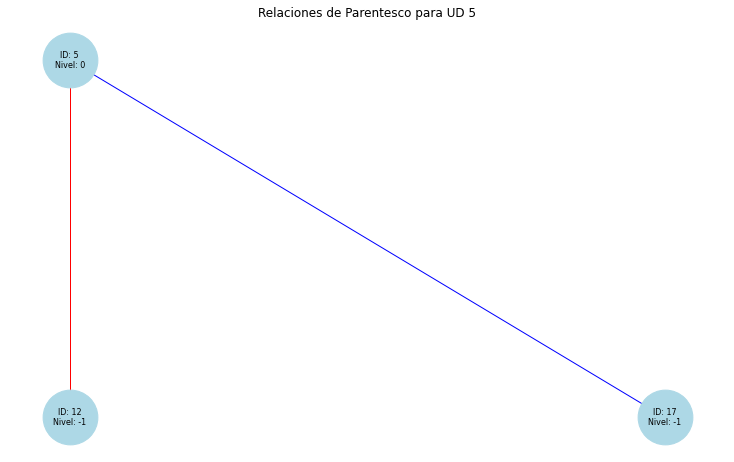

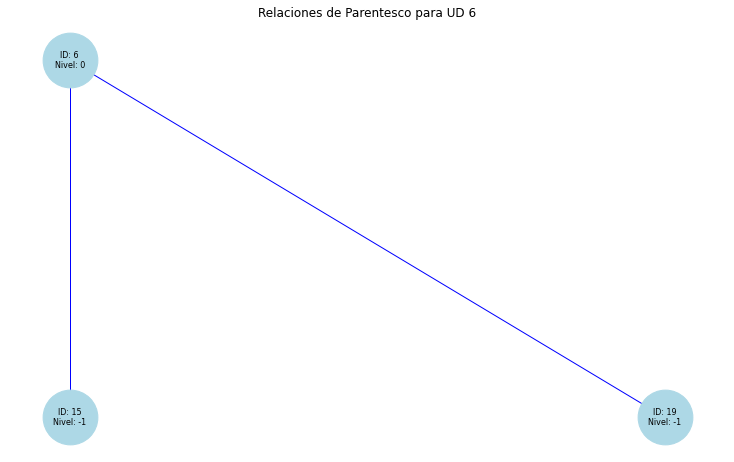

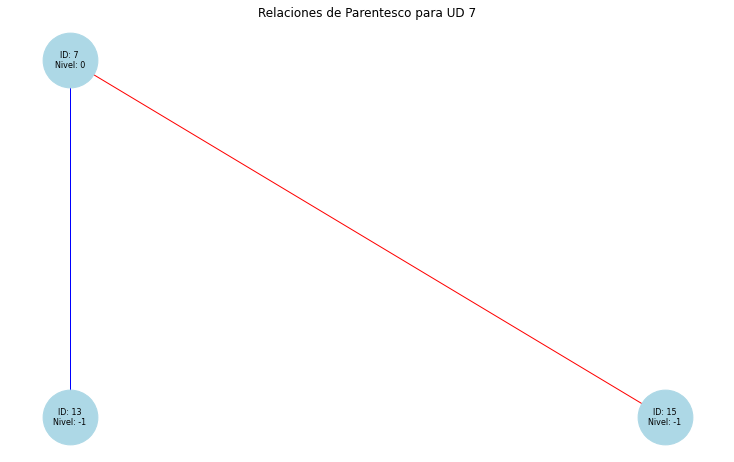

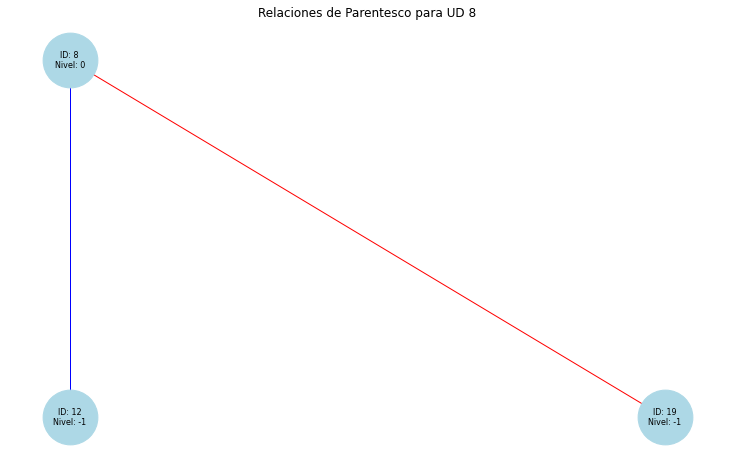

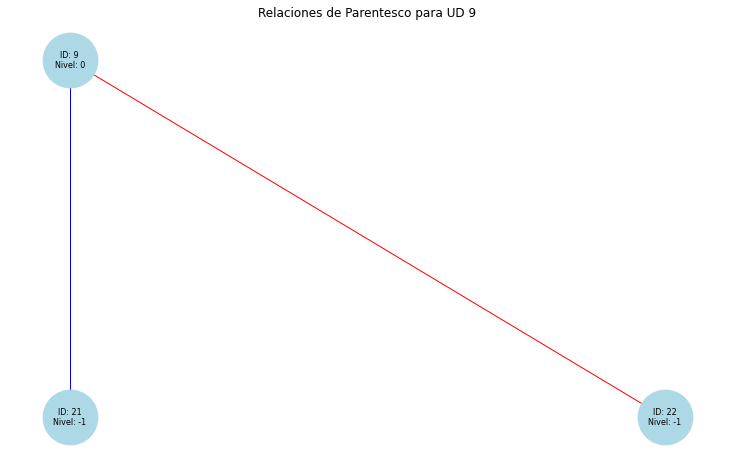

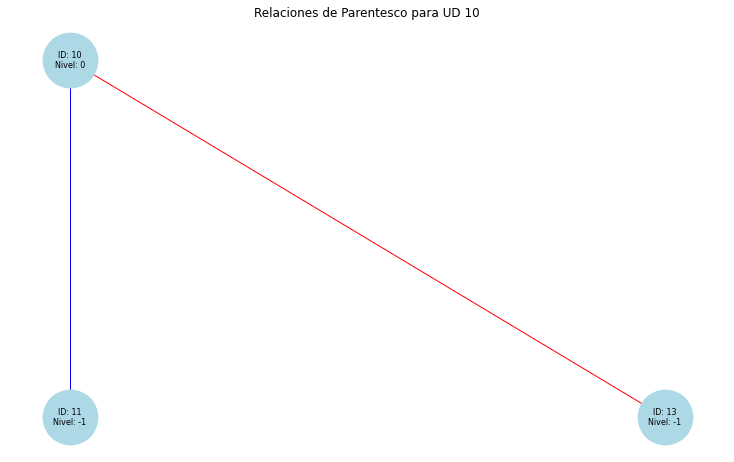

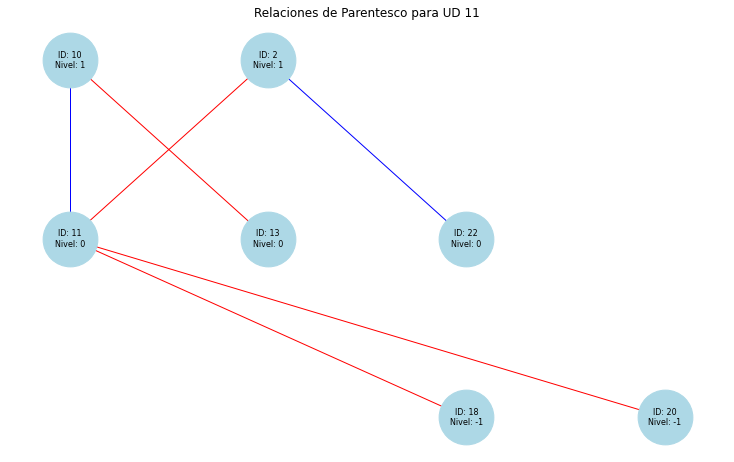

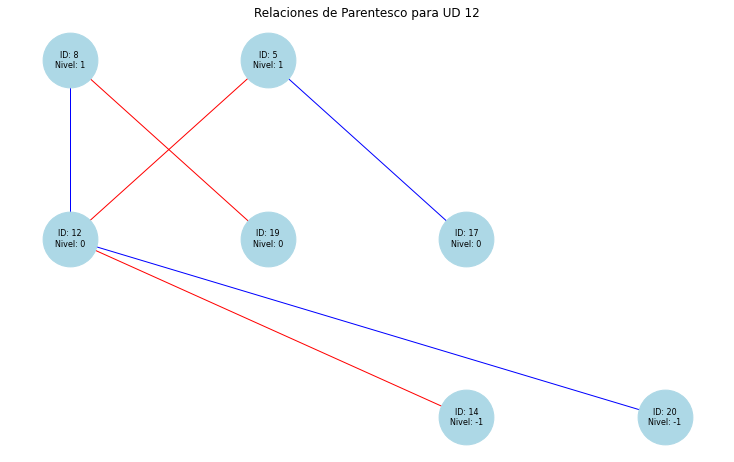

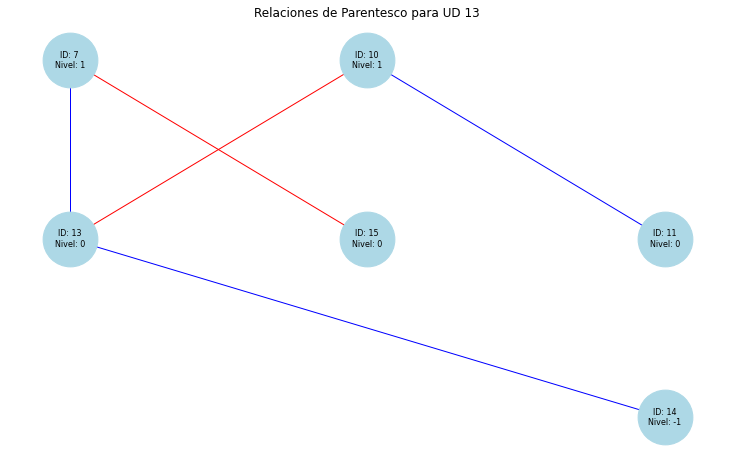

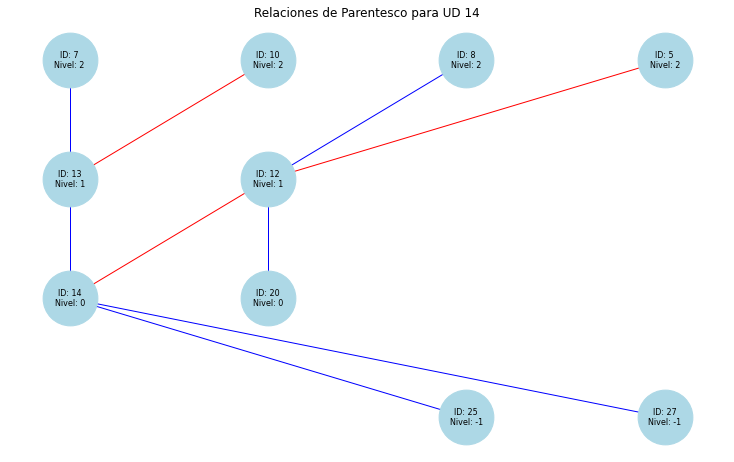

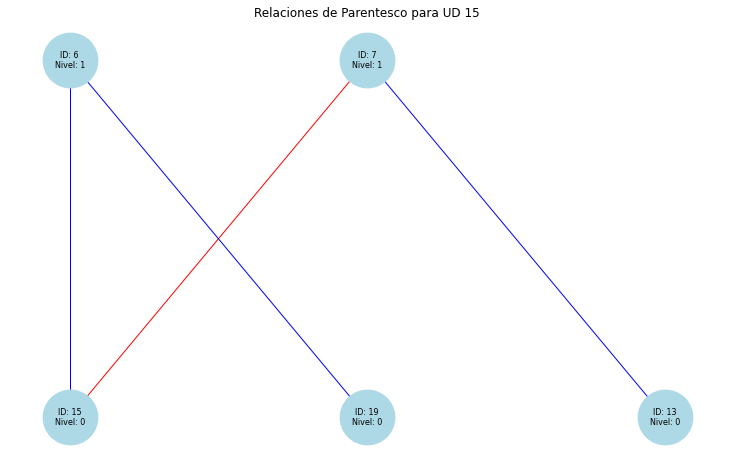

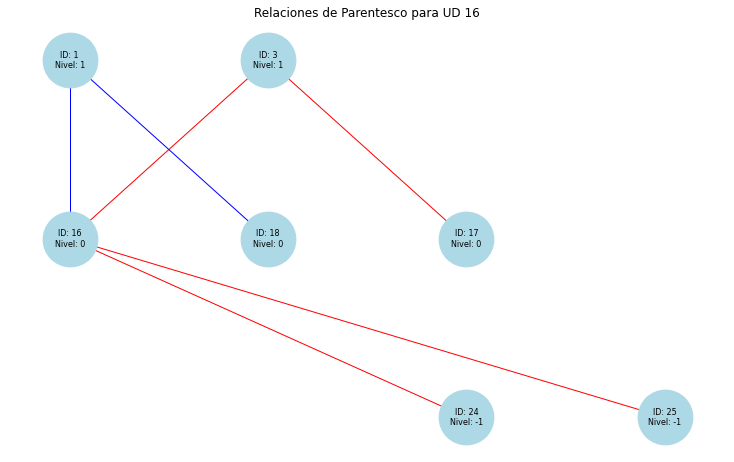

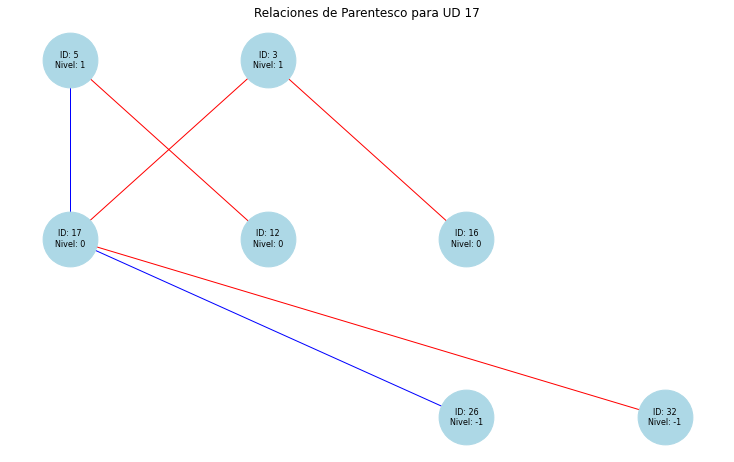

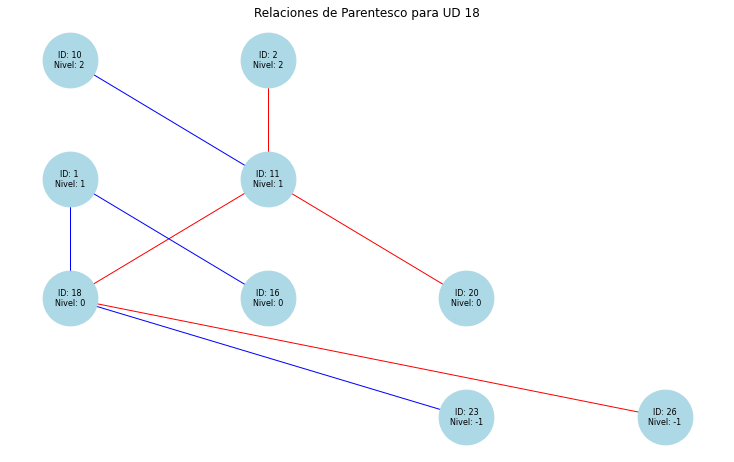

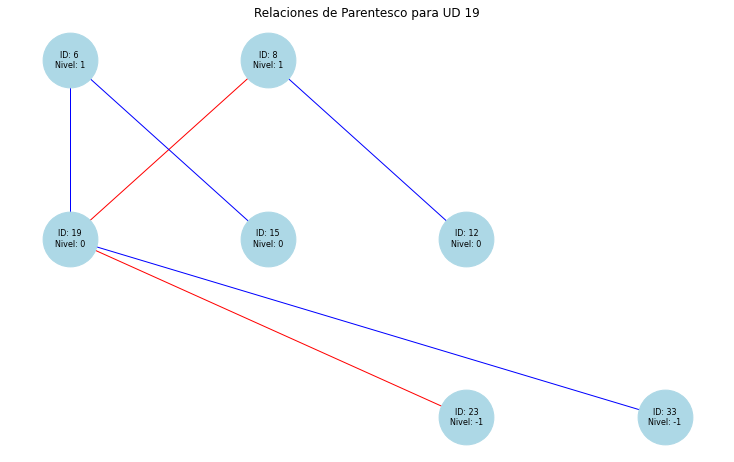

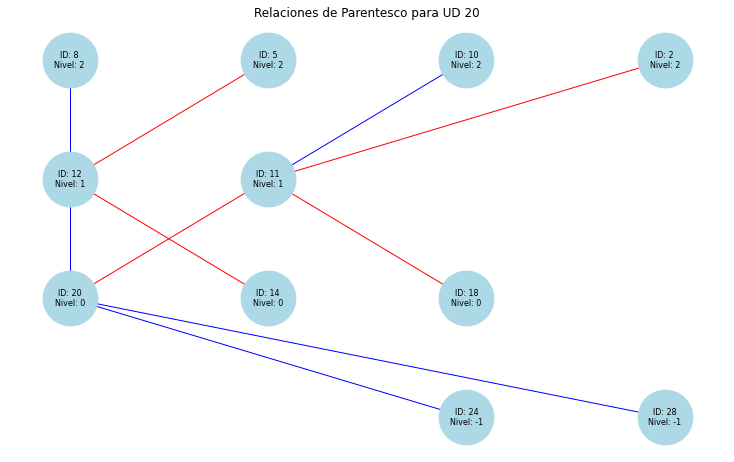

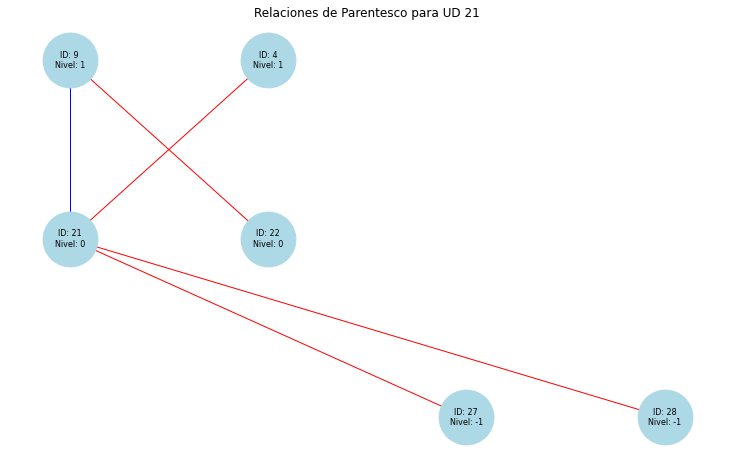

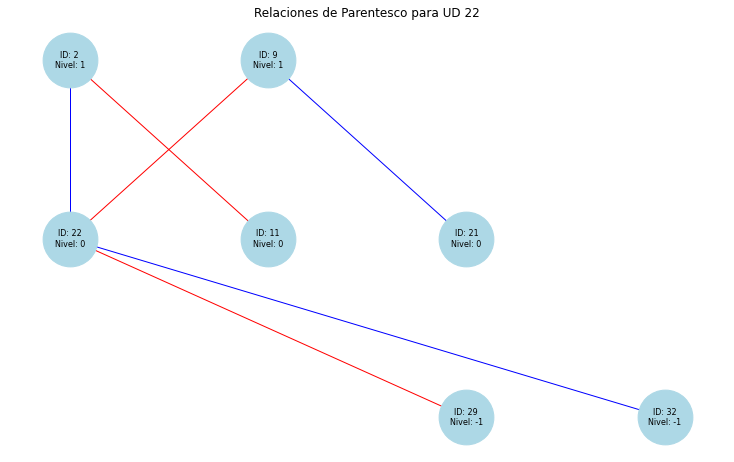

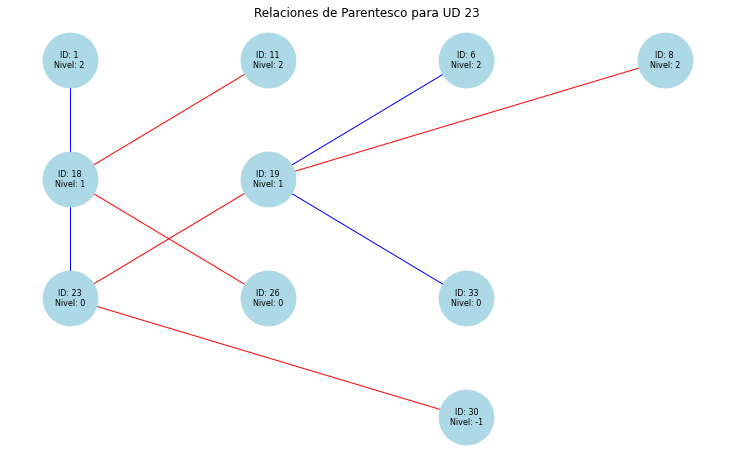

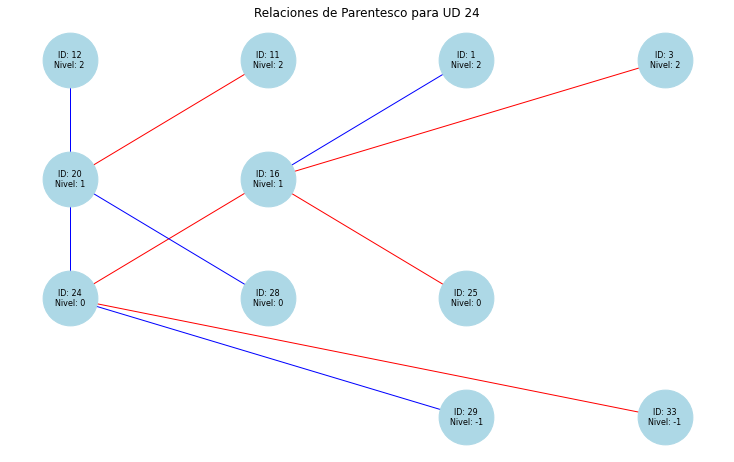

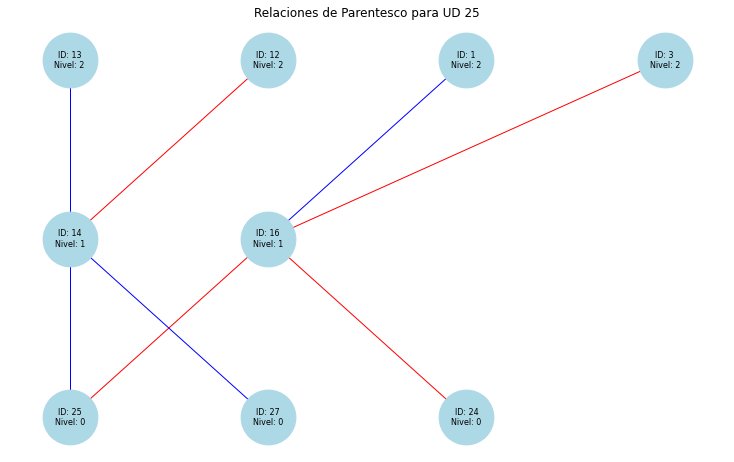

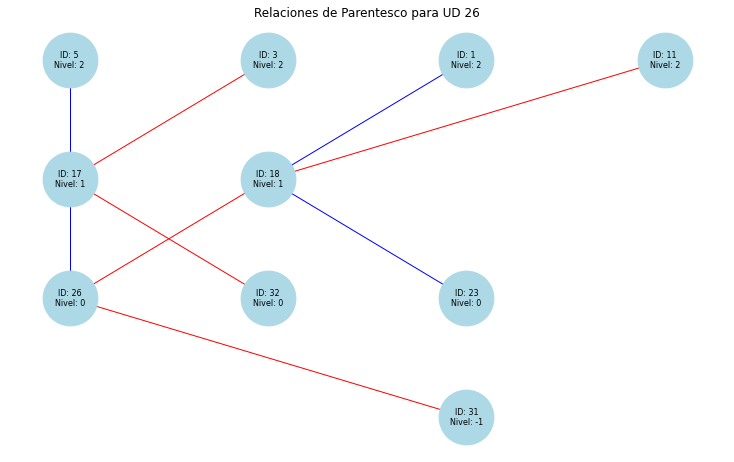

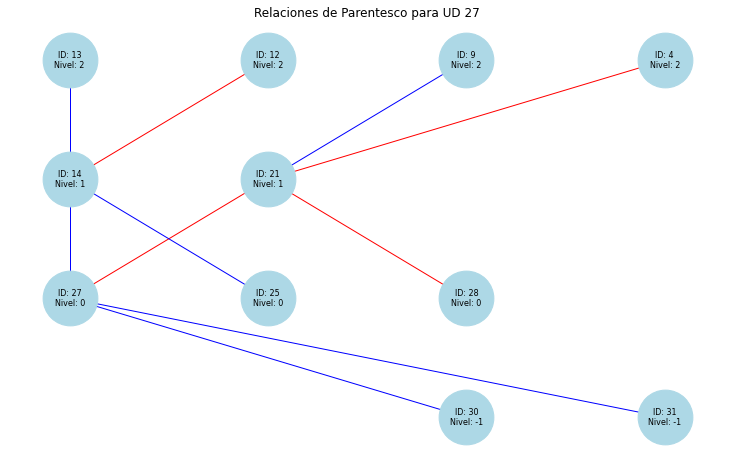

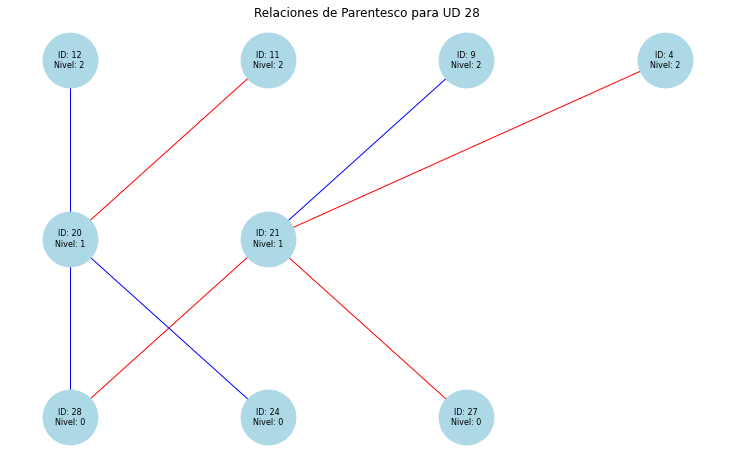

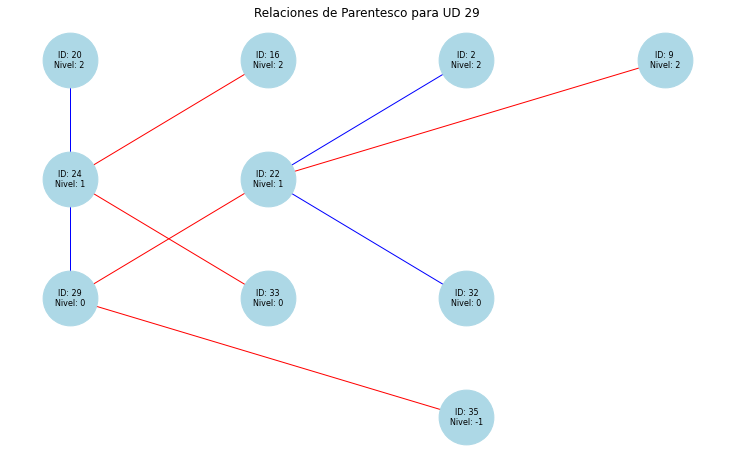

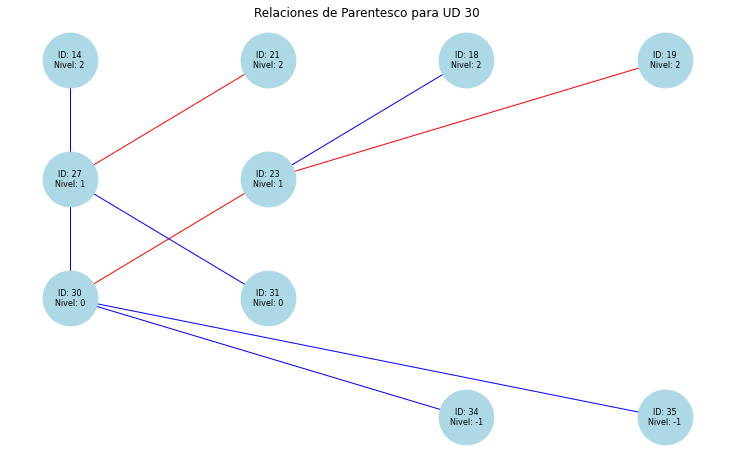

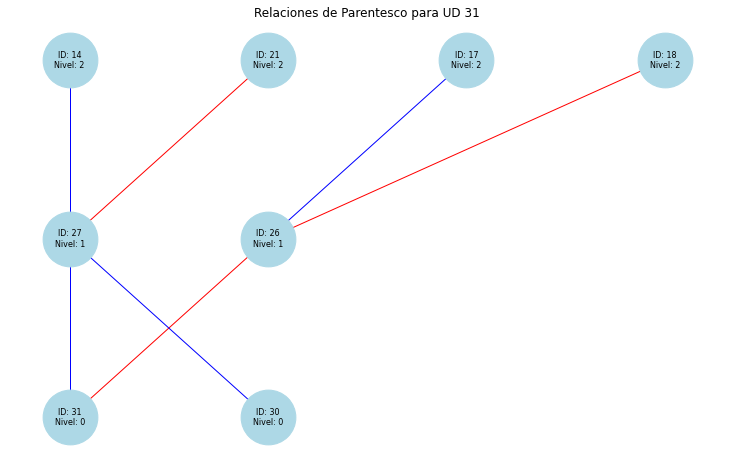

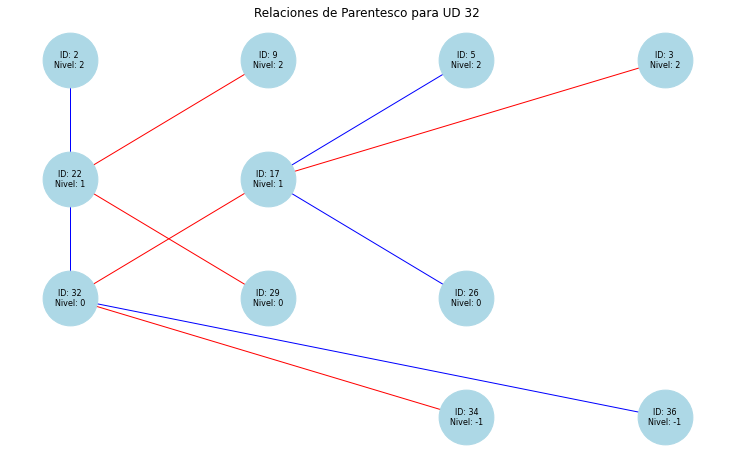

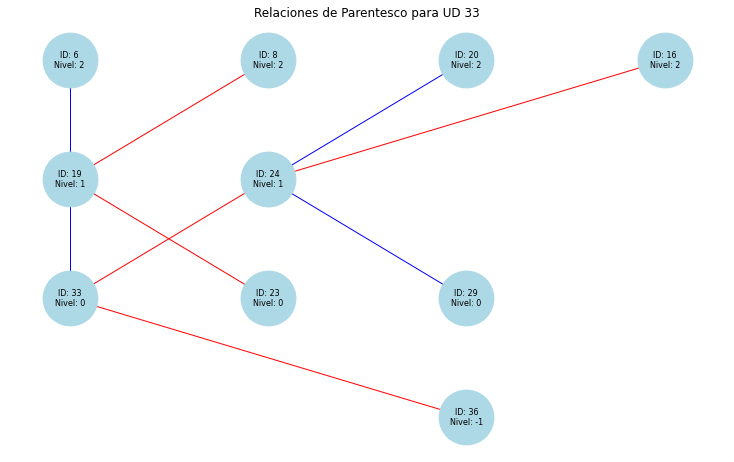

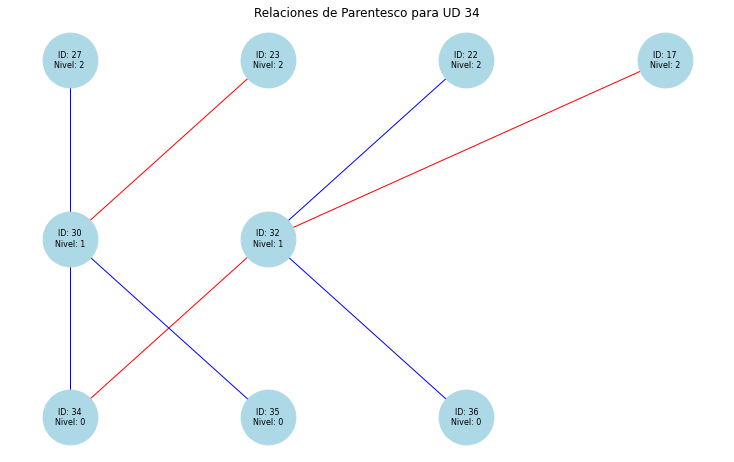

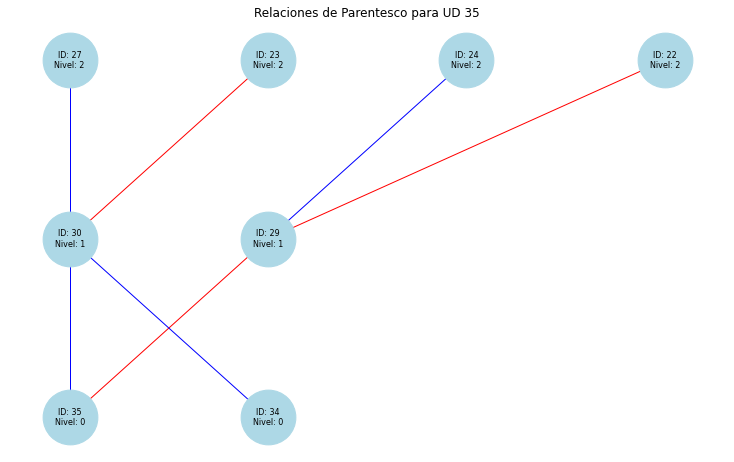

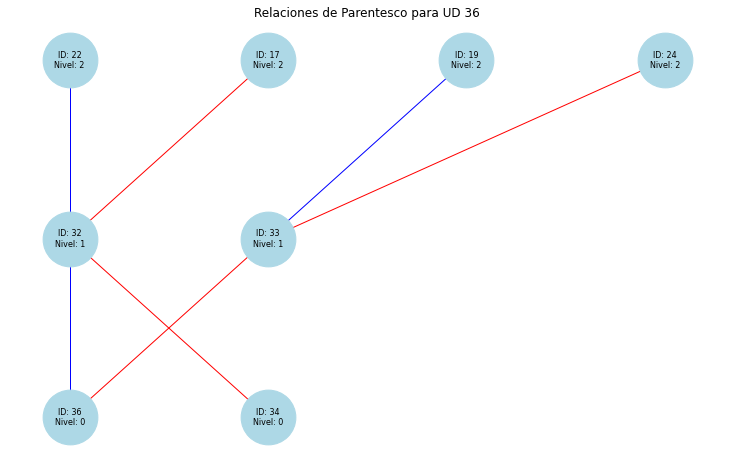

In [11]:
# Função para criar 
def create_individual_graph(ego_ud, graph):
    G = nx.Graph()

    # Nó ego
    ego_id = ego_ud.id
    G.add_node(ego_id, label=f"ID: {ego_id}\nNivel: 0")

    # Relações padre, madre e filhos
    father_id = ego_ud.parentes[0]
    mother_id = ego_ud.parentes[1]

    # Estabelecer os níveis
    if father_id is not None:
        paternal_grandfather_id = UD.uds[father_id].parentes[0]
        paternal_grandmother_id = UD.uds[father_id].parentes[1]
        G.add_node(father_id, label=f"ID: {father_id}\nNivel: 1")
        G.add_edge(father_id, ego_id, tipo_de_relacion='padre')

        # Criar os nó dos avos paternos do ego
        if paternal_grandfather_id is not None:
            G.add_node(paternal_grandfather_id, label=f"ID: {paternal_grandfather_id}\nNivel: 2")
            G.add_edge(paternal_grandfather_id, father_id)
        if paternal_grandmother_id is not None:
            G.add_node(paternal_grandmother_id, label=f"ID: {paternal_grandmother_id}\nNivel: 2")
            G.add_edge(paternal_grandmother_id, father_id, tipo_de_relacion='madre')

        # Conectar irmãos de ego á pai
        father_children = UD.uds[father_id].parentes[2]
        if father_children is not None:
            for children_id in father_children:
                if children_id is not None:
                    relationship_type = 'padre' if father_id == UD.uds[children_id].parentes[0] else 'madre'
                    G.add_node(children_id, label=f"ID: {children_id}\nNivel: 0")
                    G.add_edge(father_id, children_id, tipo_de_relacion=relationship_type)

    if mother_id is not None:
        maternal_grandfather_id = UD.uds[mother_id].parentes[0]
        maternal_grandmother_id = UD.uds[mother_id].parentes[1]
        maternal_level = 1
        G.add_node(mother_id, label=f"ID: {mother_id}\nNivel: {maternal_level}")
        G.add_edge(mother_id, ego_id, tipo_de_relacion='madre')

        # Criar os nó dos avos maternos do ego
        if maternal_grandfather_id is not None:
            G.add_node(maternal_grandfather_id, label=f"ID: {maternal_grandfather_id}\nNivel: 2")
            G.add_edge(maternal_grandfather_id, mother_id)
        if maternal_grandmother_id is not None:
            G.add_node(maternal_grandmother_id, label=f"ID: {maternal_grandmother_id}\nNivel: 2")
            G.add_edge(maternal_grandmother_id, mother_id, tipo_de_relacion='madre')

        # Conectar hermanos de ego a la madre
        mother_children = UD.uds[mother_id].parentes[2]
        if mother_children is not None:
            for children_id in mother_children:
                if children_id is not None:
                    relationship_type = 'padre' if mother_id == UD.uds[children_id].parentes[0] else 'madre'
                    G.add_node(children_id, label=f"ID: {children_id}\nNivel: 0")
                    G.add_edge(mother_id, children_id, tipo_de_relacion=relationship_type)


    # Identificar os filhos de ego
    ego_children_ids = ego_ud.parentes[2]

    # Estabelecer niveis para os filhos de ego (se não é None)
    if ego_children_ids is not None:
        for child_id in ego_children_ids:
            if child_id is not None:
                relationship_type = 'padre' if ego_id == UD.uds[child_id].parentes[0] else 'madre'
                G.add_node(child_id, label=f"ID: {child_id}\nNivel: -1")
                G.add_edge(ego_id, child_id, tipo_de_relacion=relationship_type)

    # Organizar el grafo P individual en forma de árbol genealógico
    pos = nx.kamada_kawai_layout(G)

    # Ajustar el espaciado vertical
    for node in G.nodes:
        if G.nodes[node]['label'].endswith('-1'):  # Nodos de nivel -1 (hijos)
            pos[node][1] = -1
        elif G.nodes[node]['label'].endswith('1'):
            pos[node][1] = 1
        elif G.nodes[node]['label'].endswith('2'):
            pos[node][1] = 2
        else:
            pos[node][1] = 0  # Nodos de nivel 0 (ego y hermanos)

    # Ajustar el espaciado horizontal para evitar cruces de enlaces
    layer_spacing = 0.2  # Ajusta el espaciado horizontal entre capas
    for level in set([data['label'][-1] for data in G.nodes.values()]):
        nodes_at_level = [node for node, data in G.nodes(data=True) if data['label'].endswith(level)]
        for i, node in enumerate(nodes_at_level):
            pos[node][0] = (i) * layer_spacing
    
    # Luego, para dibujar el grafo con colores personalizados en función de la relación
    edge_colors = []
    for u, v, data in G.edges(data=True):
        if 'tipo_de_relacion' in data:
            if data['tipo_de_relacion'] == 'madre':
                edge_colors.append('red')  # Color para los enlaces maternos
            else:
                edge_colors.append('blue')  # Otro color para otros enlaces
        else:
            edge_colors.append('blue')

    # Dibujar el grafo P individual con la organización deseada
    node_labels = {node: G.nodes[node]['label'] for node in G.nodes}
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=3000, node_color='lightblue', font_size=8, font_color='black', edge_color=edge_colors)
    plt.title(f"Relaciones de Parentesco para UD {ego_id}")
    plt.show()


# Iterar a través de las instancias de UD en el diccionario 'uds'
for id_ud, ud in UD.uds.items():
    # Crea un grafo P individual para cada UD como ego
    create_individual_graph(ud, UD.uds)